In [77]:
import torch
import tqdm 

def l_loss(x, l):
    return (x - torch.eye(x.shape[0])).pow(l).mean() ** (1 / l)

def make_loss_fn(l):
    if l == 2:
        return lambda x, y: torch.nn.functional.mse_loss(x, y)
    elif l == 1:
        return lambda x, y: torch.nn.functional.l1_loss(x, y)
    else:
        return lambda x, y: (x - y).pow(l).mean() ** (1 / l)
    

def whiten(matrix, **kwargs):
    steps = kwargs.get("steps", 15)
    start_lr = kwargs.get("start_lr", 0.01)
    end_lr = kwargs.get("end_lr", 0.001)
    l_identity = kwargs.get("l_identity", 2)
    l_distance = kwargs.get("l_distance", 2)

    distance_penalty = kwargs.get("distance_penalty", 1)
    match_norm_penalty = kwargs.get("match_norm_penalty", 0)
    mode = kwargs.get("mode", "min_size")

    loss_fn_id = make_loss_fn(l_identity)
    loss_fn_dist = make_loss_fn(l_distance)

    if matrix.shape[0] <= matrix.shape[1]:
        shorter_side = 0
    else:
        shorter_side = 1

    if shorter_side == 0:
        if mode == "min_size":
            matrix = matrix / (matrix.norm(dim=-1)[:, None] + 1e-6)
        else:
            matrix = matrix / (matrix.norm(dim=0)[None, :] + 1e-6)
    else:
        if mode == "min_size":
            matrix = matrix / (matrix.norm(dim=-1)[:, None] + 1e-6)
        else:
            matrix = matrix / (matrix.norm(dim=0)[None, :] + 1e-6)

    matrix.requires_grad_(True)

    orig_matrix = matrix.clone() - matrix.mean()
    optimizer = torch.optim.SGD(
        [matrix],
        lr=start_lr,
        momentum=0.9,
        nesterov=True,
    )

    min_size = min(matrix.shape[0], matrix.shape[1])
    max_size = max(matrix.shape[0], matrix.shape[1])
    target = torch.eye(min_size).to(matrix.device) if mode == "min_size" else torch.eye(max_size).to(matrix.device)
    norm_target = torch.ones(min_size).to(matrix.device) if mode == "min_size" else torch.ones(max_size).to(matrix.device)

    losses = []
    identity_losses = []
    norm_losses = []
    dist_losses = []
    pbar = tqdm.tqdm(range(steps))
    for i in pbar:
        optimizer.zero_grad(set_to_none=True)
        pred = matrix @ matrix.T
        identity_loss = loss_fn_id(pred, target)
        loss = identity_loss
        if distance_penalty > 0:
            dist_loss = loss_fn_dist(matrix, orig_matrix)
            loss = loss + distance_penalty * dist_loss
        if match_norm_penalty > 0:
            norm_loss = torch.nn.functional.mse_loss(pred.norm(dim=-1), norm_target)
            loss = loss + match_norm_penalty * norm_loss
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        lr = start_lr * (1 - (i / steps)) + end_lr * (i / steps)
        optimizer.param_groups[0]["lr"] = lr

        with torch.no_grad():
            diff = torch.abs(pred - target)
            max_diff = diff.max().item()

            identity_losses.append(identity_loss.item())
            if distance_penalty > 0:
                dist_losses.append(dist_loss.item())
            if match_norm_penalty > 0:
                norm_losses.append(norm_loss.item())

        desc = f"Loss: {loss.item():.7f}, max diff: {max_diff:.7f}, identity loss: {identity_loss.item():.7f}"
        if distance_penalty > 0:
            desc += f", distance loss: {dist_loss.item():.7f}, distance penalty: {distance_penalty}"
        if match_norm_penalty > 0:
            desc += f", norm loss: {norm_loss.item():.7f}, match norm penalty: {match_norm_penalty}"
        pbar.set_description(desc)

    return matrix, dict(identity_losses=identity_losses, norm_losses=norm_losses, dist_losses=dist_losses)

In [42]:
import transformers

gpt = transformers.AutoModelForCausalLM.from_pretrained("gpt2", cache_dir="/fsx/datasets/huggingface/hub")
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2", cache_dir="/fsx/datasets/huggingface/hub")

text = "Hello, how are you?, Yes, I am fine, thank you. What is your name? My name is John."
tokenized = tokenizer(text, return_tensors="pt")



/efs/ethan-home/.conda/envs/leo-train/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [78]:
out = gpt(**tokenized, labels=tokenized.input_ids)
out.loss.backward()

In [79]:
grad = gpt.transformer.h[0].attn.c_attn.weight.grad

In [102]:
whitened_grad, losses = whiten(grad, 
                            steps=100,
                            start_lr=1.0, 
                            end_lr=1.0, 
                            distance_penalty=0.0, 
                            match_norm_penalty=0.5, 
                            mode="min_size", 
                            l_identity=2, 
                            l_distance=2
                            ) 


Loss: 0.0023613, max diff: 0.9318221, identity loss: 0.0023575, norm loss: 0.0000076, match norm penalty: 0.5: 100%|██████████| 100/100 [00:00<00:00, 148.60it/s]


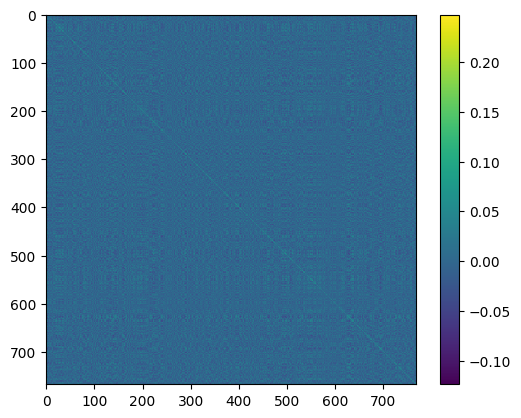

In [103]:
import matplotlib.pyplot as plt

identity_pred = whitened_grad @ whitened_grad.T
plt.imshow(identity_pred.detach())
plt.colorbar()
plt.show()


In [104]:
identity_pred

tensor([[ 0.1172,  0.0247,  0.0671,  ..., -0.0236, -0.0381,  0.0061],
        [ 0.0247,  0.0943,  0.0208,  ...,  0.0295, -0.0175,  0.0741],
        [ 0.0671,  0.0208,  0.0786,  ..., -0.0225, -0.0188, -0.0036],
        ...,
        [-0.0236,  0.0295, -0.0225,  ...,  0.0976,  0.0343,  0.0215],
        [-0.0381, -0.0175, -0.0188,  ...,  0.0343,  0.1383, -0.0338],
        [ 0.0061,  0.0741, -0.0036,  ...,  0.0215, -0.0338,  0.0916]],
       grad_fn=<MmBackward0>)